# Plot generation
### Plots for the LSTM_HC with my classsifiers

In [1]:
from scorers import scorer
import seaborn as sns
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from gym_PGFS.scorers.scorer import GuacamolMGenFailScorer
from gym_PGFS.valuation.plot_utils import plot_medians, process_output_into_dataframe

In [2]:
import os
os.chdir('../')
os.getcwd()

'/home/boto/chemPGFS/gymPGFS'

In [3]:
dsets = ['CHEMBL3888429', 'CHEMBL1909140', 'CHEMBL1909203']

In [4]:
outcomes = {}

for dset in dsets:
    with open(f"./data/lstm_hc/list_result_{dset}.pkl", "rb") as f:
        outcomes[dset] = pickle.load(f)
        print(len(outcomes[dset]))

151
151
151


In [6]:
# iterate over the lists, convert them to dataframes
outcome_dfs = {}
for name, dset in outcomes.items():
    
    scoring = GuacamolMGenFailScorer(mgenfail_data_prefix='./data/mgenfail_assays',
                                     fingerprints_used='ECFP_2_1024',
                                     name=name)

    outcome_dfs[name] = process_output_into_dataframe(dset, scoring)
    
    # save the resulting dataframe to csv
    outcome_dfs[name].to_csv(f"./data/lstm_hc/{name}_outcome.csv")
    
    # basic sanity check
    print(len(outcome_dfs[name]))

# keep the memory clean
del(outcomes)

151it [01:25,  1.77it/s]
0it [00:00, ?it/s]

275721


151it [01:38,  1.53it/s]
0it [00:00, ?it/s]

256593


151it [01:59,  1.27it/s]


261615


In [4]:
# use this block to skip preprocessing

outcome_dfs = {}

for name in dsets:
    outcome_dfs[name] = pd.read_csv(f"./data/lstm_hc/{name}_outcome.csv")

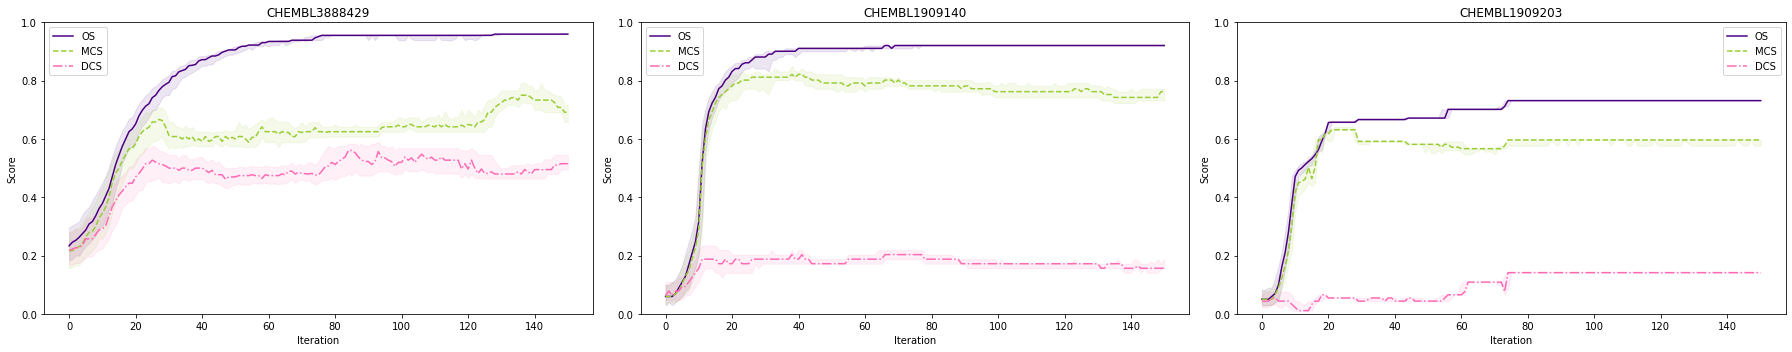

In [5]:
# make a plot
fig, axs = plt.subplots(1,3,figsize=(25,5))

for (name, data), (i, ax) in zip(outcome_dfs.items(), enumerate(axs)):
    plot_medians(data, 
                 ax,
                 (0, i),
                 name,
                 'Score',
                 'Iteration',
                 y_scale = (0.,1.),
                 x_scale = None
                )
plt.tight_layout()

### Similar line plots for the outcomes of the PGFS model.

In [6]:
from scorers import scorer
import seaborn as sns
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from gym_PGFS.scorers.scorer import GuacamolMGenFailScorer
from gym_PGFS.valuation.plot_utils import plot_medians, process_PGFS_output_into_dataset

In [ ]:
import os
os.chdir('../')
os.getcwd()

In [191]:
run_dirs = {'./data/run_B': 'CHEMBL3888429', 
            './data/run_A': 'CHEMBL1909140', 
            './data/run_C': 'CHEMBL1909203'}

In [100]:
outcomes = {}

for location, name in run_dirs.items():
    # load the pickle
    with open(f"{location}/smiles_collected.pkl", "rb") as f:
        outcomes[name] = pickle.load(f)
        print(len(outcomes[name]))
    
    # fire up the scorer
    scoring = GuacamolMGenFailScorer(mgenfail_data_prefix='./data/mgenfail_assays',
                                 fingerprints_used='ECFP_2_1024',
                                 name=name)
    
    # convert into dataframe
    outcomes[name] = process_PGFS_output_into_dataset(outcomes[name], scorer)
        
    # save the dataframe as csv for future use
    outcomes[name].to_csv(f"{location}/smiles_collected.csv")

,index,smiles,epoch,type,value
0,0,Cc1cccc(-c2[nH]c(CNc3cc[nH]n3)nc2-c2ccc3nccnc3...,0,OS_MODE,0.191667
1,1,O=C1N(Cc2cncn2CCN2CCC(O)CC2)CCN1c1cccc(OC(F)(F...,0,OS_MODE,0.179167
2,2,CNC(=O)c1n[nH]c2cc(NC(O)=NC(COC)c3ccccc3)ncc12,0,OS_MODE,0.201389
3,3,CC(=NNC(N)=S)C(O)c1ccc([N+](=O)[O-])cc1,0,OS_MODE,0.4625
4,4,COCc1c(C(=O)NCc2ccc(C)cc2)oc2ccccc12,0,OS_MODE,0.166667
...,...,...,...,...,...
9995,412,CC(Nc1ccc(F)cc1)=C1C(=O)CN(C)C(=O)C1CNc1nc(N)n...,3,MCS_MODE,0.308333
9996,413,N#CCCN(c1ccc(F)c(F)c1)c1ccnc(Nc2ccc(C(=O)Nc3cc...,3,MCS_MODE,0.282778
9997,414,NC(=O)c1ccc(SSc2ccc(Cl)cc2C(N)=O)cc1,3,MCS_MODE,0.158333
9998,415,CC(CCCC(C)C)=C(C=NOCCC#N)C(C)C,3,MCS_MODE,0.088889


Index(['index', 'smiles', 'epoch', 'type', 'value'], dtype='object')


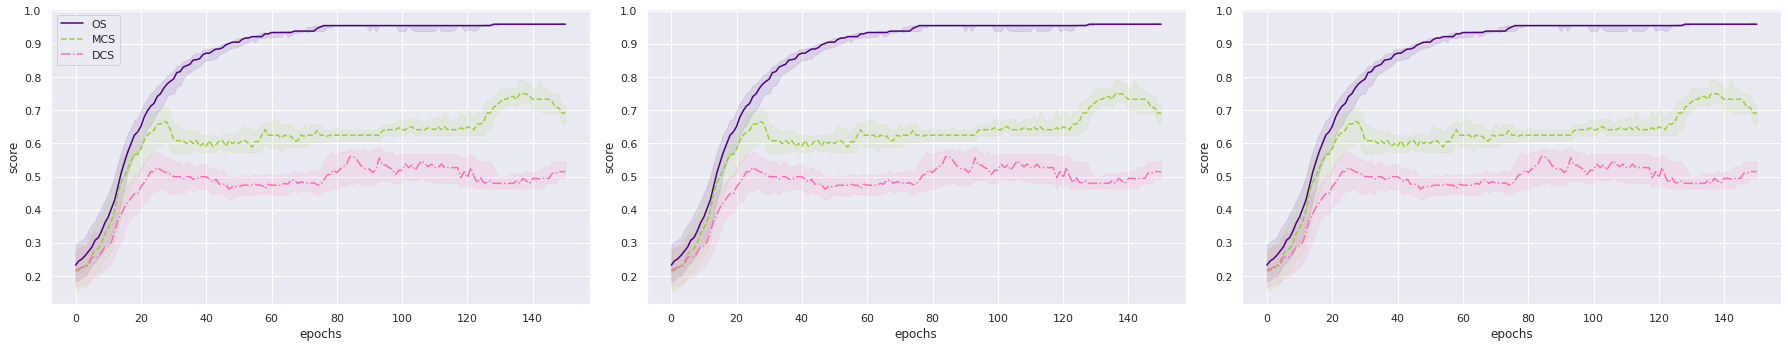

In [180]:
fig, axs = plt.subplots(1,3,figsize=(25,5))
for i, ax in enumerate(axs):
    plot_medians(dddf, ax, not i)
plt.tight_layout()

In [147]:
print(len(lol[80]))

523


In [148]:
setLOL = {x for x in lol[80]}
len(setLOL)

523

In [156]:
testarr = dddf[(dddf['epoch']==80) & (dddf['type']=='OS_MODE')].value
testarr

169380    0.938889
169381    0.955556
169382    0.938889
169383    0.955556
169384    0.955556
            ...   
169898    0.955556
169899    0.955556
169900    0.955556
169901    0.930556
169902    0.955556
Name: value, Length: 523, dtype: object

In [161]:
testarr.quantile(0.5), testarr.quantile(0.25), testarr.quantile(0.75)

(0.9555555555555556, 0.9555555555555556, 0.9555555555555556)

In [162]:
dddf[(dddf['epoch']==80) & (dddf['type']=='OS_MODE')].groupby(by=['value']).count()

,index,smiles,epoch,type
value,,,,
0.658333,1,1,1,1
0.666667,1,1,1,1
0.683333,1,1,1,1
0.730556,1,1,1,1
0.738889,1,1,1,1
0.772222,1,1,1,1
0.808333,1,1,1,1
0.851389,1,1,1,1
0.855556,1,1,1,1


### Similar plot, but for the PGFS